# **PACKAGES**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ast
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from gensim.test.utils import get_tmpfile
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline

pd.set_option('display.max_columns', 500)

# **FUNCTIONS**

In [31]:
def get_dictionary(doc_clean):
    """
    EXTRACT VOCABULARY FROM CORPUS (GENSIM CORPORA)
    -----------------------------------------------
    Input  : Clean Document
    Output : Term Dictionary
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    return gensim.corpora.Dictionary(doc_clean)


In [49]:
def get_normTF_matrix(doc_clean):
    """
    GET NORMALIZED TERM-FREQUENCY MATRIX
    ------------------------------------
    Input  : Clean document
    Output : Document Term Frequency Matrix
    """

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. 
    dictionary = gensim.corpora.Dictionary(doc_clean)

    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    TFmat = pd.DataFrame(0,
                         columns=[i for i in range(len(doc_clean))],
                         index=[i for i in range(len(dictionary))]
                        )
    i=0
    for doc in doc_clean:
        vec = [0 for i in range(len(dictionary))]
        for wrd, freq in dictionary.doc2bow(doc):
            vec[wrd] = round(freq / len(doc), 4)
        TFmat[i] = vec
        i+=1
    return TFmat

In [50]:
def get_IDF_matrix(doc_clean, useTransfertDict=True):
    """
    GET IDF MATRIX
    --------------
    Input  : clean document
    Output : IDF Matrix
    """
    # Create vocabulary
    if useTransfertDict:
        vocabulary = common_dictionary
    else:
        vocabulary = gensim.corpora.Dictionary(doc_clean)
    
    # Creating tf matrix
    TF_matrix = get_TF_matrix(doc_clean)
    
    # Converting list of documents (corpus) into IDF Matrix using dictionary prepared above.
    word_idf_values = {i:0 for i in list(vocabulary.keys())}
    
    for w in range(len(vocabulary)): 
        for doc in TF_matrix:
            for wrd in doc:
                if w == wrd[0]:
                    word_idf_values[w]+=1
        word_idf_values[w] = np.log(len(doc_clean) / (1 + word_idf_values[w]))
    return word_idf_values

In [34]:
def get_TFIDF_matrix(doc_clean):
    """
    Input  : clean document
    Purpose: create TFIDF matrix
    Output : TFIDF Matrix
    """
    # Creating tf matrix
    TF_matrix = get_normTF_matrix(doc_clean)

    # Create IDF
    IDF_vector = get_IDF_matrix(doc_clean)

    # initialize TFIDF as TF
    TFIDF_matrix = TF_matrix.copy()
    
    # update TF Matrix using IDF term.
    for doc in range(len(doc_clean)):
        for word, score in IDF_vector.items():
            TFIDF_matrix[doc][word] = TFIDF_matrix[doc][word] * score
    return TFIDF_matrix

In [51]:
def create_gensim_lsi_model(clean_documents_list, k=None):
    """
    CREATE LSI MODEL (GENSIM) 
    Input  : clean document, dictionary
    Purpose: create LSI model (Latent Semantic Indexing) 
             from corpus and dictionary
    Output : return LSI model
    """
    
    #LSI model consists of Singular Value Decomposition (SVD) of
    #Term Document Matrix M: M = T x S x D'
    #and dimensionality reductions of T, S and D ("Derivation")
    
    dictionary = gensim.corpora.Dictionary(doc_clean)
    
    corpus = get_TF_matrix(clean_documents_list)
    if k is not None:
        lsi_model = LsiModel(
                corpus=corpus,
                id2word=dictionary,
                num_topics=int(k)
                )
    else:
            lsi_model = LsiModel(
            corpus=corpus,
            id2word=dictionary 
            )
    print(); print(); print("="*20, "Training LSI model report", "="*20); print()
    
    print("Initial TF matrix (NwordsXNdocuments): ")
    TF = []
    for x in corpus:
        wrds = [0 for i in range(len(dictionary))]
        for i, j in x: wrds[i] = j
        TF.append(wrds)
    print(pd.np.transpose(TF))
    print()
    print("Derivation of Term Matrix T of Training Document Word Stems: ")
    print(lsi_model.get_topics())
    print()
    #Derivation of Term Document Matrix of Training Document Word Stems = M' x [Derivation of T]
    print("LSI Vectors of Training Document Word Stems: ")
    print([lsi_model[document_word_stems] for document_word_stems in corpus])
    print("="*70); print(); print()
    return lsi_model

In [52]:
def get_lsi_vector(lsi_model, clean_text):
    return lsi_model[dictionary.doc2bow(clean_text)]

In [53]:
def select_optimal_k_value(singular_values, significativity=75):
    """
    CHOOSE OPTIMAL K-VALUE (DIMENSION REDUCTION)
    --------------------------------------------
    input: singular values
    significativity:
    output: optimal number of singular values
    """
    singular_values.sort()
    lsi_model.projection.s = lsi_model.projection.s[::-1]
    sum_of_singular_values = sum(singular_values)
    s = 0; k = 0 
    while((s < significativity * sum_of_singular_values / 100) and 
          k < max(2, len(singular_values) - 2)):
        s+=singular_values[k]
        k+=1
    return(k)

In [54]:
def distance_classifier_cosine_test(classification_model, training_data, test_doc_lsi_vector, N=1):
    """
    Input  : trained classifier model, the training data (list of descriptions), lsi vectors of a document and N nearest document in the training data base
    Purpose: calculate cosine similarity matrix against all training samples
    Output : return nearest N document and classes
    """
    cosine_similarities = classification_model[test_doc_lsi_vector]

    most_similar_document_test = training_data[np.argmax(cosine_similarities)]

    #calculate cosine similarity matrix for all training document LSI vectors
    return most_similar_document_test

In [55]:
def reco_rate(ref_labels, predicted_labels):
    commun_labels = (pd.np.array(ref_labels)==pd.np.array(predicted_labels)).sum()
    return 100 * commun_labels / len(ref_labels)

# **LOAD DATA**

In [40]:
reviews = pd.read_csv("data/clean_full.csv.gzip", ### path to your dataset
                       compression='gzip',
                       low_memory=False,
                       parse_dates=['review_date', 'review_date_diner'])

In [41]:
reviews.shape

(200000, 34)

In [42]:
reviews.grp.value_counts()

cap    100000
1       48000
4       25000
3       10000
5       10000
2        4000
7        3000
Name: grp, dtype: int64

In [43]:
cap_reviews = reviews[reviews.grp == "4"]
# cap_reviews = reviews

In [44]:
corpus = cap_reviews.review_content_clean.map(lambda review: ast.literal_eval(review)).tolist()

In [45]:
def finalize_cleaning(reviews):
    reviews = [re.sub(r"\`+", "", word) for word in reviews]
    reviews = [re.sub(r"\.+", ".", word) for word in reviews]
    reviews = [re.sub(r"\.\w", "", word) for word in reviews]
    reviews = [re.sub(r"\'", ".", word) for word in reviews]
    reviews = [word for word in reviews if len(word)>1]
    return reviews

In [46]:
corpus = list(map(lambda review: finalize_cleaning(review), corpus))
corpus[0]

['recommend',
 'family',
 'restaurant',
 'anyone',
 'want',
 'exquisite',
 'food',
 '1-1',
 'attention',
 'choice',
 'get',
 'best',
 'taste',
 'acton',
 'best',
 'hidden',
 'gem']

# **CREATE WORD EMBEDDING OF WORDS**

## **LATENT SEMANTIC INDEXING (LSI)**

## **WORD2VEC (GENSIM)**

In [ ]:
path = get_tmpfile("word2vec.model")

# Create Word2Vec Model (Gensim)
W2V_model = gensim.models.Word2Vec(size=300, window=3, min_count=5, workers=4, seed=1, iter=50)
W2V_model.build_vocab(corpus[:3000])
W2V_model.train(corpus[:3000], total_examples=model.corpus_count, epochs=model.epochs)
W2V_model.save("word2vec.model")

W2V_model = gensim.models.Word2Vec.load("word2vec.model")
# model.wv.most_similar("good", topn=10)
# model.wv.most_similar("bad", topn=10)

In [13]:
embedding_matrix = dict()

for word in model.wv.vocab.keys():
    embedding_matrix[word] = list(model.wv[word])
    
embedding_matrix_w2v = pd.DataFrame(embedding_matrix)

In [14]:
embedding_matrix_w2v.head()

,recommend,family,restaurant,anyone,want,exquisite,food,attention,choice,get,best,taste,hidden,gem,nice,atmosphere,beer,airport,great,service,guy,bar,amit,fast,going,regularly,couple,year,always,excellent,menu,wide,range,say,word,lovely,place,visited,first,time,booked,celebrate,mother,birthday,party,view,experience,mixed,people,enjoyed,however,disappointed,live,locally,love,attending,regular,basis,run,italy,really,italian,value,money,consistently,eat,well,keep,returning,suggestion,improvement,would,child,.s,selection,half,portion,often,share,pizza,daughter,though,since,rather,large,husband,feel,find,staff,friendly,provide,prompt,even,busy,fantastic,size,good,evening,together,without,kid,indian,area,enjoy,home,delivery,extremely,efficient,visiting,class,make,special,friend,stopped,nearby,hotel,week,went,walk,reading,review,ta,huge,decided,ask,recommendation,decide,dish,recommended,chicken,along,rice,curry,ever,eaten,full,flavour,spicy,absolutely,delicious,sized,left,price,house,give,try,lunch,christmas,wine,list,extensive,mussel,sea,bit,salty,enough,prawn,served,stayed,many,ago,anniversary,knowing,coming,bought,afternoon,tea,two,voucher,received,member,sorry,name,welcoming,explained,chatty,intrusive,read,previous,little,concerned,thing,must,whole,asked,wanted,fresh,plate,sweet,music,playing,room,number,also,needed,jam,cream,staying,told,wish,everything,box,could,provided,cake,taken,falafel,salad,normal,fill,problem,close,quite,early,.m,normally,work,open,book,adult,attentive,making,comfortable,certainly,return,second,soon,thank,everyone,ate,bass,ok,green,olive,mushroom,sauce,horrible,idea,slow,go,drink,order,come,opened,although,n.t,walking,past,recently,noticed,...,loo,club,highlight,charcoal,skin,definately,meatball,management,character,sri,lankan,memory,pancake,lime,orange,calm,chatting,face,lunchtime,he,chorizo,skewer,roasted,guarantee,arrive,personally,patron,advice,west,life,raw,xmas,entering,possible,sense,fillet,european,create,dancing,dj,cool,fit,shocked,nan,search,craft,spotless,complementary,dennys,hubby,promptly,dairy,writing,basically,convenient,firm,beyond,mr,hesitate,ideal,eventually,cutlery,dough,unexpectedly,addition,separate,placed,behind,fully,july,warmly,transported,airy,toilet,described,hall,refurbishment,ground,wonder,funny,giving,success,deserves,hope,january,interest,balanced,happily,disappoints,rock,smell,forgot,juice,paneer,brewery,planning,friendliness,praise,arm,purley,polish,tidy,discovered,september,rich,surely,toddler,midweek,advantage,crepe,broadway,downside,complimentary,tend,clear,tudor,true,cup,rump,tart,amongst,flavor,fire,spending,single,afterwards,fruit,satisfied,waste,meaning,roy,eton,cleared,champagne,yum,wassouf,masala,plain,twickenham,chiswick,turkey,oak,layout,biryani,accommodated,£25,enthusiastic,imperial,conversation,veal,10/10,smaller,nepali,aswell,catch,heading,plan,shoulder,niyom,rating,opposite,croydon,note,north,driving,topped,antonio,bexleyheath,market,bean,tucked,rave,themed,instantly,nibble,eastern,similar,slight,humour,45,bothered,post,eats,excellence,jane,closing,recent,total,oven,enzo,mate,octopus,response,produce,competition,relatively,surbiton,glorious,test,bon,eight,fond,strawberry,rush,ample,dosa,speak,leisurely,mediterranean,gathering,phone,pepper,wondered,concern,dancer,actual,railway,confirmed,stuffed,harper,martini,flavourful,mango,lassi,overnight,chatted,foodie,vibrant,important,shopping,informative,bonus,poached,syon,theatre,rolled,tempting,football,tandoori,turtle,bay,indeed,shell,marilena,continued,chez,rarely,4th,16,emily
0,0.475479,-0.945888,-0.357512,-0.307238,0.061890,-0.066895,0.421548,-0.639898,-0.221792,-0.642222,0.039946,-0.554943,-0.218692,-0.351731,0.703610,-0.912996,0.015286,-0.402003,0.127431,-0.406872,-0.606641,0.236688,-0.195262,0.453497,-0.293948,-0.213741,-0.152332,-1.218862,-0.391873,0.078319,0.870690,0.156169,0.298027,-0.254833,-0.342412,0.651746,-0.255824,0.101317,-0.414695,-0.423197,-0.165931,-0.488241,-0.456999,-0.032806,-0.189607,-0.327534

In [15]:
embedding_matrix_w2v.shape

(300, 1720)

# **DISCOVERING KNOWLEDGE WITH EMBEDDING MATRIX**

# **DIMENSION REDUCTION (PCA)**

In [16]:
pca = PCA(n_components=3)
pca.fit(embedding_matrix_w2v.T)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [17]:
np.cumsum(pca.explained_variance_ratio_)

array([0.11079594, 0.1905293 , 0.25079419])

In [18]:
pca_data = pd.DataFrame(pca.transform(embedding_matrix_w2v.T))
pca_data.columns = ["PC1", "PC2", "PC3"]

In [19]:
pca_data.head()

,PC1,PC2,PC3
0,1.215551,1.856942,2.157290
1,-2.392227,1.455874,0.391710
2,-1.481850,0.488314,1.448103
3,-1.132671,0.640121,2.978714
4,-0.668974,0.307760,1.625021


In [20]:
pca_data.shape

(1720, 3)

In [21]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

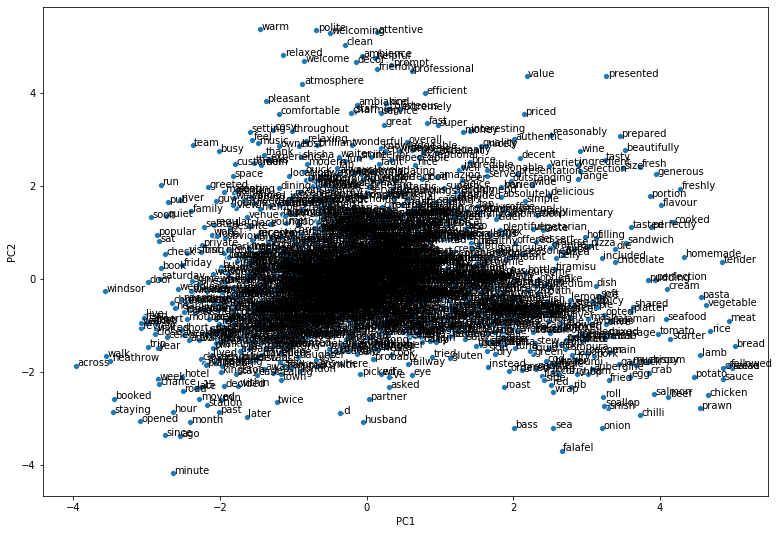

In [22]:
plt.figure(figsize = (13,9))

sns.scatterplot(pca_data.PC1, pca_data.PC2)
label_point(pca_data.PC1, pca_data.PC2, pd.Series(embedding_matrix_w2v.columns), plt.gca())

## **DIMENSION REDUCTION (T-SNE)**

In [23]:
X_embedded = TSNE(n_components=2, perplexity=5, learning_rate=300).fit_transform(embedding_matrix_w2v.T)

In [24]:
X_embedded = pd.DataFrame(X_embedded)
X_embedded.columns = ["Dimension1", "Dimension2"]

In [25]:
X_embedded.head()

,Dimension1,Dimension2
0,65.666176,-13.226261
1,-26.952377,55.380531
2,8.930273,54.853313
3,63.073677,4.395676
4,49.783073,-0.785823


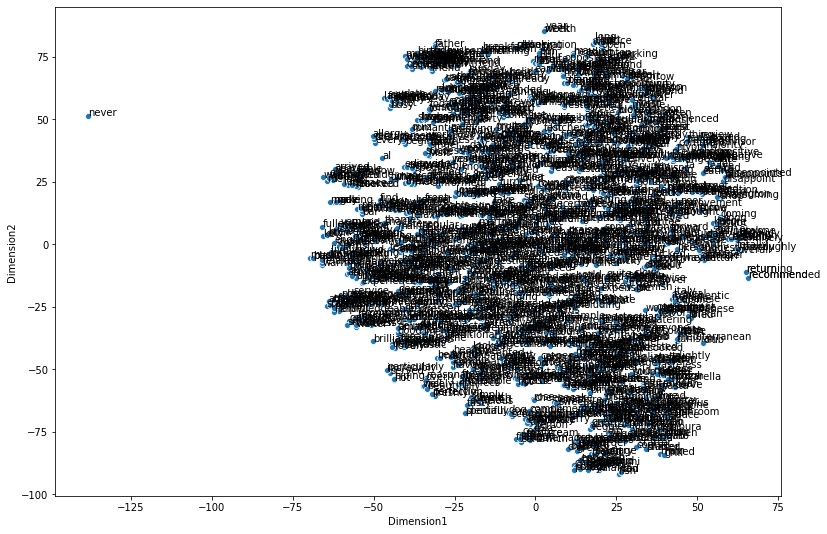

In [26]:
plt.figure(figsize = (13,9))

sns.scatterplot(X_embedded.Dimension1, X_embedded.Dimension2)
label_point(X_embedded.Dimension1, X_embedded.Dimension2, pd.Series(embedding_matrix_w2v.columns), plt.gca())

# GENERATING THE REVIEWS EMBEDDING MATRIX 

### **LATENT SEMANTIC INDEXING (LSI)**

### **WORD2VEC**

In [27]:
vectors = []
for review_content in corpus:
    review_vector = []
    for word in review_content:
        try:
            review_vector.append(list(model.wv[word]))
        except KeyError:
            pass            
    vectors.append([sum(i) for i in zip(*review_vector)])

In [28]:
review_embedding_w2v = pd.DataFrame(vectors)

In [29]:
review_embedding_w2v = review_embedding/300

In [30]:
review_embedding_w2v.columns = ["Dimension_"+str(i) for i in range(300)]

In [31]:
cap_reviews_w2v = cap_reviews.reset_index()

In [32]:
cap_reviews_w2v = pd.concat([cap_reviews['review_rating'], review_embedding], axis=1).dropna()

In [33]:
cap_reviews_w2v

,review_rating,Dimension_0,Dimension_1,Dimension_2,Dimension_3,Dimension_4,Dimension_5,Dimension_6,Dimension_7,Dimension_8,Dimension_9,Dimension_10,Dimension_11,Dimension_12,Dimension_13,Dimension_14,Dimension_15,Dimension_16,Dimension_17,Dimension_18,Dimension_19,Dimension_20,Dimension_21,Dimension_22,Dimension_23,Dimension_24,Dimension_25,Dimension_26,Dimension_27,Dimension_28,Dimension_29,Dimension_30,Dimension_31,Dimension_32,Dimension_33,Dimension_34,Dimension_35,Dimension_36,Dimension_37,Dimension_38,Dimension_39,Dimension_40,Dimension_41,Dimension_42,Dimension_43,Dimension_44,Dimension_45,Dimension_46,Dimension_47,Dimension_48,Dimension_49,Dimension_50,Dimension_51,Dimension_52,Dimension_53,Dimension_54,Dimension_55,Dimension_56,Dimension_57,Dimension_58,Dimension_59,Dimension_60,Dimension_61,Dimension_62,Dimension_63,Dimension_64,Dimension_65,Dimension_66,Dimension_67,Dimension_68,Dimension_69,Dimension_70,Dimension_71,Dimension_72,Dimension_73,Dimension_74,Dimension_75,Dimension_76,Dimension_77,Dimension_78,Dimension_79,Dimension_80,Dimension_81,Dimension_82,Dimension_83,Dimension_84,Dimension_85,Dimension_86,Dimension_87,Dimension_88,Dimension_89,Dimension_90,Dimension_91,Dimension_92,Dimension_93,Dimension_94,Dimension_95,Dimension_96,Dimension_97,Dimension_98,Dimension_99,Dimension_100,Dimension_101,Dimension_102,Dimension_103,Dimension_104,Dimension_105,Dimension_106,Dimension_107,Dimension_108,Dimension_109,Dimension_110,Dimension_111,Dimension_112,Dimension_113,Dimension_114,Dimension_115,Dimension_116,Dimension_117,Dimension_118,Dimension_119,Dimension_120,Dimension_121,Dimension_122,Dimension_123,Dimension_124,Dimension_125,Dimension_126,Dimension_127,Dimension_128,Dimension_129,Dimension_130,Dimension_131,Dimension_132,Dimension_133,Dimension_134,Dimension_135,Dimension_136,Dimension_137,Dimension_138,Dimension_139,Dimension_140,Dimension_141,Dimension_142,Dimension_143,Dimension_144,Dimension_145,Dimension_146,Dimension_147,Dimension_148,Dimension_149,Dimension_150,Dimension_151,Dimension_152,Dimension_153,Dimension_154,Dimension_155,Dimension_156,Dimension_157,Dimension_158,Dimension_159,Dimension_160,Dimension_161,Dimension_162,Dimension_163,Dimension_164,Dimension_165,Dimension_166,Dimension_167,Dimension_168,Dimension_169,Dimension_170,Dimension_171,Dimension_172,Dimension_173,Dimension_174,Dimension_175,Dimension_176,Dimension_177,Dimension_178,Dimension_179,Dimension_180,Dimension_181,Dimension_182,Dimension_183,Dimension_184,Dimension_185,Dimension_186,Dimension_187,Dimension_188,Dimension_189,Dimension_190,Dimension_191,Dimension_192,Dimension_193,Dimension_194,Dimension_195,Dimension_196,Dimension_197,Dimension_198,Dimension_199,Dimension_200,Dimension_201,Dimension_202,Dimension_203,Dimension_204,Dimension_205,Dimension_206,Dimension_207,Dimension_208,Dimension_209,Dimension_210,Dimension_211,Dimension_212,Dimension_213,Dimension_214,Dimension_215,Dimension_216,Dimension_217,Dimension_218,Dimension_219,Dimension_220,Dimension_221,Dimension_222,Dimension_223,Dimension_224,Dimension_225,Dimension_226,Dimension_227,Dimension_228,Dimension_229,Dimension_230,Dimension_231,Dimension_232,Dimension_233,Dimension_234,Dimension_235,Dimension_236,Dimension_237,Dimension_238,Dimension_239,Dimension_240,Dimension_241,Dimension_242,Dimension_243,Dimension_244,Dimension_245,Dimension_246,Dimension_247,Dimension_248,Dimension_249,Dimension_250,Dimension_251,Dimension_252,Dimension_253,Dimension_254,Dimension_255,Dimension_256,Dimension_257,Dimension_258,Dimension_259,Dimension_260,Dimension_261,Dimension_262,Dimension_263,Dimension_264,Dimension_265,Dimension_266,Dimension_267,Dimension_268,Dimension_269,Dimension_270,Dimension_271,Dimension_272,Dimension_273,Dimension_274,Dimension_275,Dimension_276,Dimension_277,Dimension_278,Dimension_279,Dimension_280,Dimension_281,Dimension_282,Dimension_283,Dimension_284,Dimension_285,Dimension_286,Dimension_287,Dimension_288,Dimension_289,Dimension_290,Dimension_291,Dimensi

In [36]:
cap_reviews.to_csv('data/cap_reviews_embedding.csv.gzip', index=False, compression='gzip')

# REVIEW CLASSIFIER

In [55]:
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV, Perceptron
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [43]:
# Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    #BaggingClassifier(),
    #GradientBoostingClassifier(),
    #RandomForestClassifier(),
    
    #LM
    # LogisticRegressionCV(),
    RidgeClassifierCV(),
#     Perceptron(),
    
    #Naives Bayes
#     BernoulliNB(),
#     GaussianNB(), 
    
    #Nearest Neighbor
#     KNeighborsClassifier(),
    
    #SVM
    SVC(),
    
    #Discriminant Analysis
#     LinearDiscriminantAnalysis(),
#     QuadraticDiscriminantAnalysis(),
    
    #XGBoost
    XGBClassifier(),
    
    #LightGBM
    LGBMClassifier(),
    ]

In [44]:
cap_reviews = pd.read_csv('data/cap_reviews_embedding.csv.gzip', compression='gzip')
cv_split = StratifiedKFold(n_splits = 5, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(cap_reviews[review_embedding.columns],
                                                    cap_reviews['review_rating'],
                                                    stratify=cap_reviews['review_rating'], 
                                                    test_size=0.25)

In [ ]:
MLA_columns = ['MLA Name','MLA Train Accuracy Mean','MLA Train Accuracy STD',
               'MLA Test Accuracy Mean','MLA Test Accuracy STD']

MLA_compare = pd.DataFrame(columns = MLA_columns)
MLA_predict = y_train
idx = 0
for alg in MLA:
    print(f'Fitting: {alg}')
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[idx , 'MLA Name'] = MLA_name
    
    cv_results = cross_validate(alg, 
                                X_train, 
                                y_train, 
                                cv=cv_split,
                                scoring = 'accuracy',
                                return_train_score=True)

    MLA_compare.loc[idx, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[idx, 'MLA Train Accuracy STD'] = -cv_results['train_score'].std()
    MLA_compare.loc[idx, 'MLA Validation Accuracy Mean'] = cv_results['test_score'].mean()    
    MLA_compare.loc[idx, 'MLA Validation Accuracy STD'] = -cv_results['test_score'].std()
    MLA_compare.loc[idx, 'MLA Fit Time'] = cv_results['fit_time'].mean()
    
    idx += 1

Fitting: RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]), class_weight=None, cv=None,
                  fit_intercept=True, normalize=False, scoring=None,
                  store_cv_values=False)
Fitting: SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [ ]:
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False).head(10)

We applied basic classifiers (with default hyperparameters) with similar validation scores. Here is what we observe based on the cross-validation:
* __Ridge Classifier__ : Outperforms the other models in terms of __training time__ and __generalization error__ (i.e. difference in training and testing score)
* __LightGBM Classifier__ : Tends to __overfit the train data__ (would require regularization hyperparamater tuning)
* __XGBoost Classifier__ : Performs the __worst__ in terms of __training time__
* __Support Vector Machines__ : Showed a __good balance__ between __training time__, __validation score__, and __generalization error__

In [ ]:
######################################################################
#  TODO BEFORE THURSDAY
#  - PREDICT THE RATING FOR A FEW REVIEWS AND COMPARE TO TEST VALUES
#  - USE FASTTEXT / GENSIM AND COMPARE RESULTS (OPTIONAL)
######################################################################